# Portfolio 1

In the following exercises, we are going to analyse response time data  from a recent paper [(Legrand et al., 2021)](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) using PyMC3.

### Imports

In [1]:
### IMPORTS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats

sns.set_context('talk')

### Read the data

In [2]:
# Load data frame
df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

## Exercise 1 - Preprocessing

This data frame contains behavioral results from a lot of participants, doing a lot of different tasks. The data of interest for us are stored in the `ConfidenceRT` column. This is the time the participant takes to rate a confidence rating scale. Before we go to the analysis part, we should filter this data frame a bit.

* Here we only want to analyze the modality labeled as `Intero`, and drop the other one. 
* We only want to keep the `Subject` and the `ConfidenceRT` columns. 
* Sometimes, no responses were made by the participant, so the column potentially contains NaN values that should be removed. 
* Because we are just testing new models here, we only want to analyze a sub-sample of the data to save time and memory, so we are going to analyze subjects whose ID ends with a `7` and drop the rest of the participants.

You should end up with a data frame containing 2 columns, 1158 rows, and the response time data from 20 participants in total. If you have difficulties doing this filtering process, you can just skip this question and use the entire `ConfidenceRT` column for the next questions.

### Filtering using pandas

In [3]:
filtered_df = df[(df["Modality"] == "Intero") 
                 & (df["Subject"].str.endswith("7"))][["Subject", "ConfidenceRT"]].dropna().reset_index(drop = True)


## Exercise 2 - Gaussian model
There are many ways to describe response time distribution. The most intuitive and simple model would be to use a normal distribution and use the mean and precision of this distribution as parameters of interest for each subject.

We know from the experimental design that the response time cannot be less than 0 seconds or more than 5 seconds. Our first guess will be to use a normal distribution with a mean $\mu$ and a standard deviation $\sigma$. The mean might come from another normal distribution centered at 2.5. We don't want it to be too informative so the standard deviation will be set at 10. The standard deviation might come from a HalfCauchy distribution with a beta parameter set to `2`.

* Use PyMC3 to fit this model to the responses from the first participant only (`sub_0027`) and create one plot using Arviz to synthesize your results.
* Why did you choose this plot?
* Describe what is represented in your plot
* What information should we check if we want to make sure that the MCMC chain from this model can be trusted?

### Filter to get Subject 27 only

In [4]:
data = filtered_df[filtered_df["Subject"] == "sub_0027"] #get subject 27

### First Model
For the first model, we start off by specifying our model without sampling. This is done for two reasons. First, we are going to run a lot of models in this portfolio, so it makes sense to make a general function for doing this across all models. Secondly, this allows us to visualize the model specification and whether it is correctly defined.

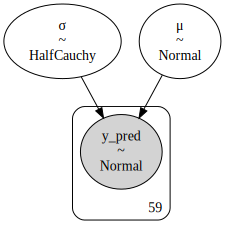

In [5]:
with pm.Model() as firstModel:
    ## PRIORS ##
    μ = pm.Normal("μ", mu = 2.5, sd = 10)
    σ = pm.HalfCauchy("σ", beta = 2)
    
    ## LIKELIHOOD ##
    y_pred = pm.Normal("y_pred", mu = μ, sd = σ, observed = data["ConfidenceRT"].values)
    
#get plate notation to visualize what the model looks like
pm.model_to_graphviz(firstModel) 

### Functions
Here we define a general function, which takes a pm.Model() and samples the posterior, the prior predictive and posterior predictive. These are all stored in a dictionary, which makes it easy to access the different samples when they are needed.

In [6]:
def model_dict(model):
    '''
    Description: Takes a pm.Model() object, and samples from the posterior, the prior predictive and the posterior predictive
    Input [pm.Model]: model to test
    Output [dict]: dictionary containing "model", "trace", "prior" and "posterior".
    '''
    #sample from the model
    with model:
        trace = pm.sample(tune = 2000, return_inferencedata = False)
        priorpc = pm.sample_prior_predictive(300)
        postpc = pm.sample_posterior_predictive(trace, 300)
    
    #return in dictionary format
    mod_dict = {
        "model": model,
        "trace": trace,
        "prior": priorpc,
        "posterior": postpc,
    }
    
    return mod_dict

In [7]:
normal_dict = model_dict(firstModel) #using the function on the first model
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 36 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


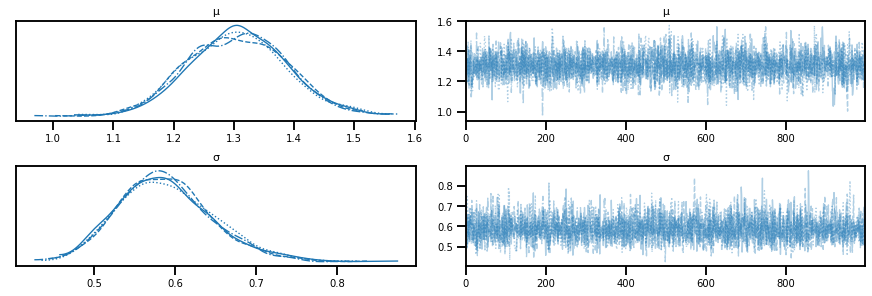

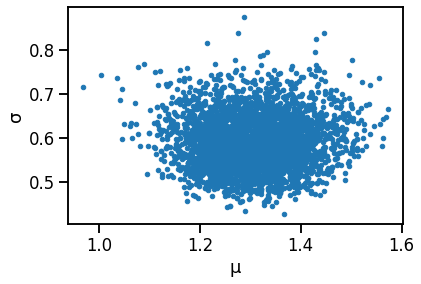

In [8]:
with normal_dict["model"]: #index the dictionary to get the model 
    az.plot_trace(normal_dict["trace"]) #plot the trace
    sum_trace = az.summary(normal_dict["trace"]) #get the summary of the trace
    az.plot_pair(normal_dict["trace"]) #plot trace to see whether μ and σ are correlated

### Initial glance of our model
On first glance, it does seem like we are getting a nice fit to the data. Traces look healthy, and we don't get any divergences. Furthermore, our parameter space is not compressed, and our parameters are independent from each other. But we need to do a prior predictive check, and a posterior predictive check. We also see an $R-hat$ of 1, indicating that the different chains are sampling very similar distributions.

### Function for plotting prior predictive check and posterior predictive check
We also define a new function, which takes the dictionary from the previous functions output as input. It then uses the functions for plotting from arviz to plot the prior and posterior predictive. The first of these plots is used to get a visual representation of whether our priors makes sense for the data. The prior predictive is calculated without inference on the most likely values of our parameters. The posterior predictive is our fit to the data, and is used to visually estimate whether our model is capturing the data accurately. 

In [9]:
def plot_pps(model_dict):
    az.plot_ppc(az.from_pymc3(posterior_predictive=
                              model_dict["prior"], 
                              model=model_dict["model"])) #prior
    
    az.plot_ppc(az.from_pymc3(posterior_predictive=
                              model_dict["posterior"], 
                              model=model_dict["model"])) #posterior

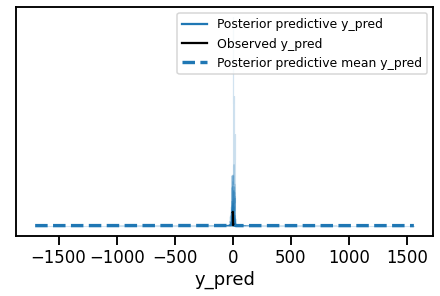

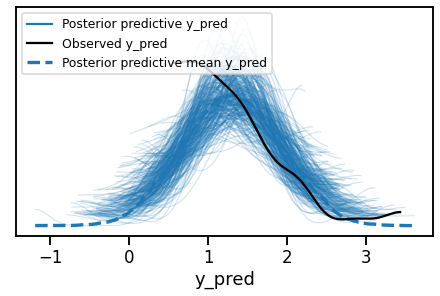

In [10]:
plot_pps(normal_dict)

### Comments on plots
Here is where we have clear evidence that our model is *very* wrong. Let us start by investigating the first plot of the prior predictive distribution. If we know from our experimental design that $RT \in [0, 5]$, then our priors should reflect that information. Currently, they don't. As mentioned, the prior predictive plot shows samples directly from our priors and predicts $y$ from them, whereas the posterior predictive shows the models prediction of $y$ after learning from the data. This also acts as our rationale for choosing these plots. We have reason for quite strong priors in this instance ($RT \in [0, 5]$). Although much of the probability mass resides in this area in our posterior, the posterior predictive plot shows, that our model is actually a quite poor fit to the data. We really should limit all of our probability mass to be within $[0,5]$.
The posterior also reflects, that our model doesn't capture the pattern in the data. Response times are not normally distributed at all, so our posterior fails to capture data.



## Exercise 3 - Precision

You want to compare your results with another model from the literature that describes the normal distribution using precision ($\lambda$), and not the standard deviation ($\sigma$). We know that: $$\sigma = \frac{1}{\sqrt{\lambda}}$$

* Use `az. summary` to extract the $\sigma$ value from the previous model, and convert it into a precision ($\lambda$) value.

We isolate $\lambda$:

$$ \sigma = \frac{1}{\sqrt{\lambda}} \implies \sigma \sqrt{\lambda} = 1 \implies \lambda = \frac{1}{\sigma^2}$$

In [11]:
lamb = 1/sum_trace["mean"]["σ"]**2
lamb

2.8825006269438864

## Exercise 4 - posterior predictive checks

It turns out that this gaussian model is a terrible one for many reasons. We can explore this a bit more by checking the posterior predictive.

* Extract the posterior predictive for this model using the default parameters from PyMC3.
* Plot posterior predictive checks using built-in Arviz function.
* What does this plot tells us? 
* What are the 2 main disadvantages here for response time data?

### Answers for Exercise 4
This was exactly what we did in Exercise 2, and the reader can go back and read the reflections there. The only thing left to cover is the 2 main disadvantages for response time data for our model. The first of which is a long tailed distribution. The normal distribution is a symmetrical distribution, and thus cannot capture long tails when it is only in one direction. This also relates to the second major disadvantage for normal distributions when modelling response time data. Response time data have a hard cut-off, as can be seen in our plot of the posterior predictive check. By their nature, response time data cannot be negative values, and are often lognormally distributed instead of normally distributed. 

## Exercise 5 - A better model

The normal distribution is indeed a poor fit for response time data. Other sources suggest that the Gamma distribution or the shifted Wald distribution might do a better job (see [this paper](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00102/full)). You can find all these distributions already implemented in PyMC3.

Using the same data from subject 27, fit, plot, and summarize the following models separately.

* The gamma model

$$ y \sim \mathcal{Gamma}(mu=\alpha, sigma=\beta)$$
$$ \alpha \sim \mathcal{Uniform}(0, 5)$$
$$ \beta \sim  \mathcal{Uniform}(0, 5)$$

* The Wald model

$$ y \sim \mathcal{Wald}(\mu, \lambda)$$
$$ \mu \sim \mathcal{Uniform}(0, 5)$$
$$ \lambda \sim  \mathcal{Uniform}(0, 20)$$

### Plan for fitting the models
Here we first specify our models. However, we here specify three models; two for the Gamma model, and one for the Wald model. The reason for this is that the Gamma-distribution has different shape parameters. It was not completely clear for us at the time which one of these choices were suggested. 

In [12]:
with pm.Model() as modelGamma:
    ### PRIORS ###
    α = pm.Uniform("α", 0, 5)
    β = pm.Uniform("β", 0, 5)
    
    ### LIKELIHOOD ###
    y_pred = pm.Gamma("y_pred", 
                      mu = α, 
                      sigma = β, 
                      observed = data["ConfidenceRT"].values) 


with pm.Model() as modelGammaAlt:
    ### PRIORS ###
    α = pm.Uniform("α", 0, 5)
    β = pm.Uniform("β", 0, 5)
    
    ### LIKELIHOOD ###
    y_pred = pm.Gamma("y_pred", 
                      alpha = α, 
                      beta = β, 
                      observed = data["ConfidenceRT"].values) 

with pm.Model() as modelWald:
    ### PRIORS ###
    μ = pm.Uniform("μ", 0, 5)
    λ = pm.Uniform("λ", 0, 20)
    
    ### LIKELIHOOD ###
    y_pred = pm.Wald("y_pred", 
                     μ, 
                     λ, 
                     observed = data["ConfidenceRT"].values)

### Use function to sample the models

In [13]:
gamma_dict = model_dict(modelGamma)
gammaAlt_dict = model_dict(modelGammaAlt)
wald_dict = model_dict(modelWald)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 40 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 37 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6897473454102194, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7187386037048983, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains ma

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 39 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


### Plot traces to see if everything looks good
#### Gamma

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,1.315,0.074,1.179,1.457,0.002,0.001,1837.0,1816.0,1870.0,1911.0,1.0
β,0.555,0.061,0.448,0.671,0.001,0.001,2048.0,2027.0,2108.0,2229.0,1.0


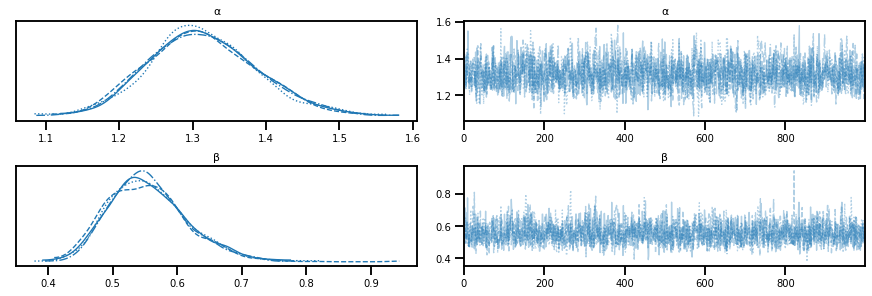

In [14]:
az.plot_trace(gamma_dict["trace"])
az.summary(gamma_dict["trace"])

#### Gamma Alt

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,4.528,0.405,3.783,4.999,0.043,0.031,88.0,88.0,169.0,54.0,1.03
β,3.483,0.390,2.745,4.148,0.038,0.027,104.0,104.0,169.0,47.0,1.03


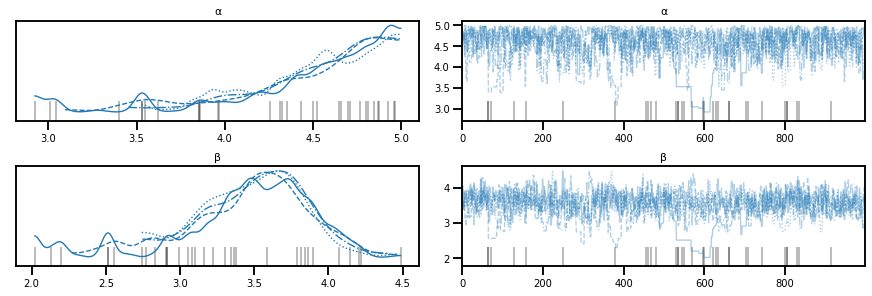

In [15]:
#with Gamma_dict["model"]:
az.plot_trace(gammaAlt_dict["trace"])
az.summary(gammaAlt_dict["trace"])

#### Wald

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,1.316,0.077,1.175,1.459,0.001,0.001,3219.0,3191.0,3251.0,2337.0,1.0
λ,7.188,1.317,4.852,9.717,0.024,0.018,2902.0,2656.0,3064.0,1905.0,1.0


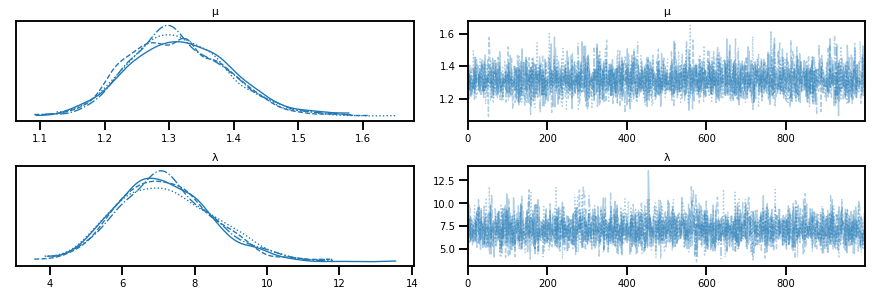

In [16]:
#with Wald_dict["model"]:
az.plot_trace(wald_dict["trace"])
az.summary(wald_dict["trace"])

## Prior and Posterior Predictive Checks

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something fail

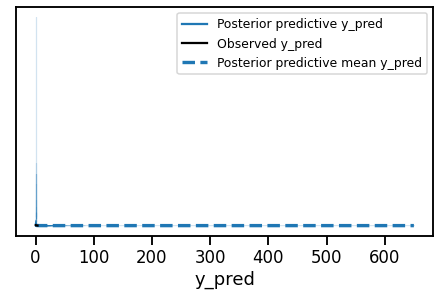

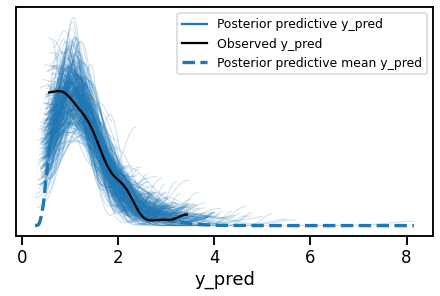

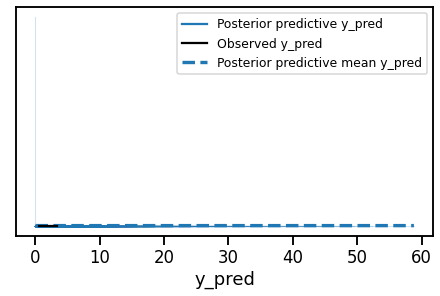

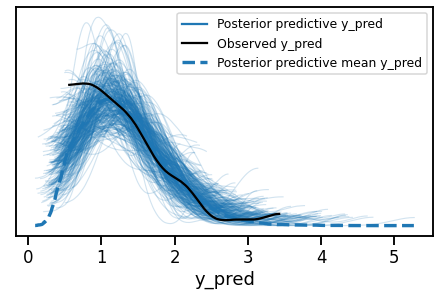

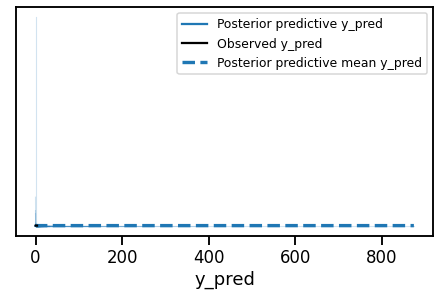

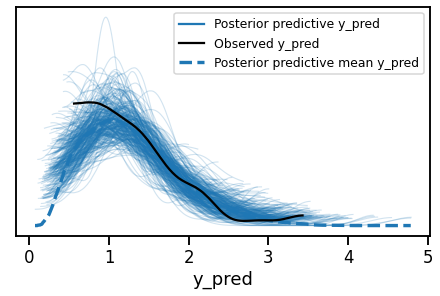

In [17]:
for i in [wald_dict, gamma_dict, gammaAlt_dict]:
    plot_pps(i)

It seems like the sampling was succesful. Moreover, we can see from our posterior predictive plots that these distributions are much better models of the data. Moreover, it seems like the Wald model is a very good fit for our data. 

## Exercise 6 - Plotting model results

Using the parameters estimates from the previous models, Matplotlib, Seaborn, and the `scipy.stats`module, try to reproduce the following plot
![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/wald_gamma.png)
:

**Hint**: You can use the gamma function from Scipy to estimate the probability density function, but you will have to create your own Wald function to make it work with the parameters `mu` and `lam` estimated by PyMC3 (see the formula [here](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)).

#### Specify function for probability density function for Wald

In [18]:
def wald_function(x, μ, λ):
    return np.sqrt(λ/(2*np.pi*x**3))*np.exp(-(λ*(x-μ)**2)/(2*μ**2*x))

#### Setup variables for plotting

In [19]:
x = np.linspace(0, 5, 1000) #create linspaces for plotting

In [20]:
wald_sum = az.summary(wald_dict["trace"]) #use summary to get mean values
mu, lamb = wald_sum["mean"]["μ"], wald_sum["mean"]["λ"] #extract mean values

In [21]:
gamma_sum = az.summary(gammaAlt_dict["trace"]) #-- // --
alpha, beta = gamma_sum["mean"]["α"], gamma_sum["mean"]["β"] # -- // --

### Plot for the two different models 

<ipython-input-18-f408afcbd041>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(λ/(2*np.pi*x**3))*np.exp(-(λ*(x-μ)**2)/(2*μ**2*x))
<ipython-input-18-f408afcbd041>:2: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt(λ/(2*np.pi*x**3))*np.exp(-(λ*(x-μ)**2)/(2*μ**2*x))


(0.0, 0.95)

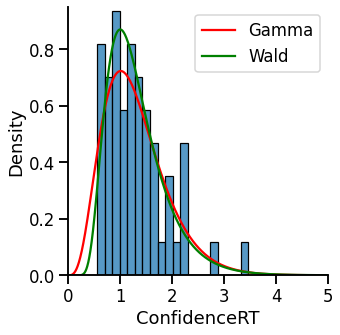

In [22]:
sns.displot(data, x = "ConfidenceRT", binwidth = 0.145, stat = "density")
plt.plot(x, stats.gamma.pdf(x, a = alpha, scale = 1/beta), color = "red")
sns.lineplot(x, wald_function(x, mu, lamb), color = "green")
plt.legend(labels = ["Gamma", "Wald"])
plt.xlim(0, 5)
plt.ylim(0, 0.95)

From the plot we can see that the Wald model more accurately captures the distribution. The Gamma model allocates too much probability mass in thrange between 0-0.4, whereas the Wald model has very little probability mass in that range. 

## Exercise 6 - Model comparison

Compare the previous models (normal distribution, Gamma, Wald). Which one should we choose? What are the metrics/indexes you use to make your decision?

### Answer:
Here we are using arviz to use model comparison between our different models. As a metric, we first use WAIC and LOO:

#### WAIC

In [23]:
cmp_df = az.compare({'Normal': normal_dict["trace"],
                   'Gamma': gamma_dict["trace"],
                     "GammaAlt": gammaAlt_dict["trace"],
                    "Wald": wald_dict["trace"]},
                    method = 'stacking',
                   ic = "waic")
cmp_df

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densiti

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Wald,0,-43.769727,1.842385,0.000000,1.000000e+00,6.223041,0.000000,True,log
Gamma,1,-45.519318,1.944094,1.749590,0.000000e+00,6.400793,0.985467,True,log
GammaAlt,2,-45.651640,1.028176,1.881913,0.000000e+00,5.455743,1.079661,False,log
Normal,3,-53.597664,3.216866,9.827936,4.618528e-14,8.436581,3.965455,True,log


#### LOO

In [24]:
cmp = az.compare({'Normal': normal_dict["trace"],
                   'Gamma': gamma_dict["trace"],
                  "GammaAlt": gammaAlt_dict["trace"],
                    "Wald": wald_dict["trace"]},
                    method = "BB-pseudo-BMA")
cmp

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Wald,0,-43.776664,1.849322,0.000000,0.697221,8.081915,0.000000,False,log
Gamma,1,-45.533791,1.958567,1.757127,0.154585,6.151933,0.989191,False,log
GammaAlt,2,-45.652135,1.028671,1.875471,0.146381,5.205371,1.081116,False,log
Normal,3,-53.625352,3.244554,9.848688,0.001813,6.013462,3.980471,False,log


<AxesSubplot:xlabel='Log'>

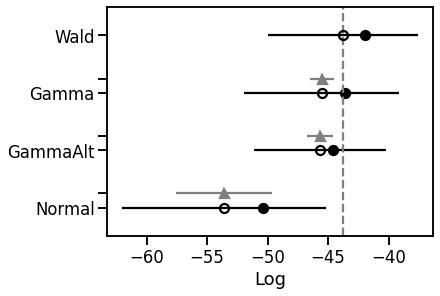

In [25]:
az.plot_compare(cmp_df)

#### Conclusions on Model Comparison
Both metrics suggest that the Wald model is the best model for the data. This was also what the initial posterior predictive check suggested. Moreover, we can also see that both the Gamma and the Wald model are a way better fit to the data than our Normal model. 

## Exercise 7 - Decision

Imagine the following (completely fictitious) situation: Previous researches have shown that the $\mu$ parameter estimated from the Wald distribution is associated with the anxiety level of the participant. The lower this parameter is, the faster the participant is at confidence rating, and the greater the anxiety level is. If $\mu$ is below 1.2, the anxiety level is considered clinically relevant and the participant should be oriented to a specialist.

You want to make a decision concerning subject 27, and you want to make it probabilistically (i.e. you want to take the decision, but also estimate how sure you are about this decision).

* Given your estimation of $\mu$ from the previous model, do you consider this score to be clinically relevant here?
* What is the probability that $\mu$ is acless thany below 1.2 for this participant?

#### Answer
First, we want all the samples of $\mu$, so that we can access the whole distribution. 

In [26]:
mu_samples = wald_dict["trace"]["μ"] ## extract the samples 

Next, we plot the KDE of the distribution and insert quantiles of 25%, 50% and 75% to get an overview of the distribution:

<AxesSubplot:>

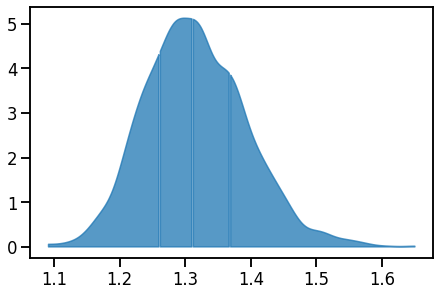

In [27]:
az.plot_kde(mu_samples, quantiles = [0.25, 0.5, 0.75])

The above plot shows the samples of $\mu$, and displays the quantiles $[0.25, 0.5, 0.75]$ as vertical lines. This gives the first indication, that less than 25% of the probability mass is below $\sim 1.28$. In order to be more precise with how much probability is less than $1.2$, we turn to the plot_posterior function:

<AxesSubplot:title={'center':'μ'}>

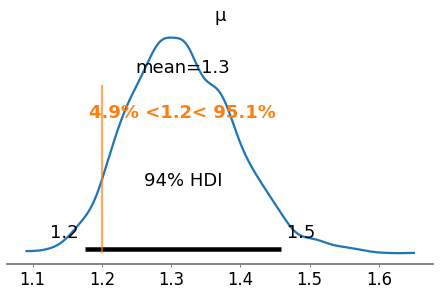

In [28]:
az.plot_posterior(data = wald_dict["trace"], var_names = ["μ"], ref_val = 1.2)

The above plot shows that the model estimates that there is a 95% probability that $1.2 \leq \mu$. We should therefore not take actions, as the subject is not clinically relevant.

## Exercise 8 - Hierarchical model

Using the entire dataset this time (20 subjects), we are going to fit a hierarchical Wald model. Instead of fixing the prior of the parameters of the Wald function, we want to sample them from hyperpriors (i.e each participant will have its own $\mu$ and $\lambda$ parameters coming from a unique normal distributionm and we want to estimate the mean and standard deviation of these distributions). The hierarchical model for $i = 20$ participants is defined by:

$$ y_{i} \sim \mathcal{Wald}(\mu_{i}, \lambda_{i})$$
$$ \mu_{i} \sim \mathcal{N}(\mu_{\mu}, \sigma_{\mu})$$
$$ \lambda_{i} \sim  \mathcal{N}(\mu_{\lambda}, \sigma_{\lambda})$$

$$\mu_{\mu} \sim \mathcal{Uniform}(0, 100)$$
$$\mu_{\lambda} \sim \mathcal{Uniform}(0, 100)$$

$$\sigma_{\mu} \sim \mathcal{HalfCauchy}(10)$$
$$\sigma_{\lambda} \sim \mathcal{HalfCauchy}(10)$$


### Answer
First, we need to setup our vectors of interest. We need an $idx$ vector, used for indexing the values of all subjects. We also need $reaction_times$, which is our observed reaction times. Lastly, we need the number of groups. This is used to assign the correct number of shapes in our parameters. 

#### Setup vectors

In [29]:
idx = pd.Categorical(filtered_df['Subject']).codes #get our idx vector for all subjects
reaction_times = filtered_df["ConfidenceRT"].values #get observed values as a np.array
groups = len(np.unique(idx)) #determine amount of subjects

#### Specifying the model
We specify the hierachical model with hyperpriors, which are passed to the priors of each group:

In [30]:
with pm.Model() as hierachicalWald:
    ### HYPER PRIORS ###
    μ_μ = pm.Uniform("μ_μ", 0, 100)
    μ_λ = pm.Uniform("μ_λ", 0, 100)
    
    σ_μ = pm.HalfCauchy("σ_μ", 10)
    σ_λ = pm.HalfCauchy("σ_λ", 10)
    
    ### PRIORS ###
    μ = pm.Normal("μ", mu = μ_μ, sd = σ_μ, shape = groups)
    λ = pm.Normal("λ", mu = μ_λ, sd = σ_λ, shape = groups)
    
    ### LIKELIHOOD ###
    y_pred = pm.Wald("y_pred", μ[idx], λ[idx], observed = reaction_times)

#### Sample the model using the function:

In [31]:
hierachical_dict = model_dict(hierachicalWald)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, μ, σ_λ, σ_μ, μ_λ, μ_μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 108 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\distributions\continuous.py:1049: RuntimeWarning: invalid value encountered in sqrt
  - mu / (2.0 * lam) * np.sqrt(4.0 * mu * lam * v + (mu * v) ** 2)
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\distributions\continuous.py:1053: RuntimeWarning: overflow encountered in power
  value = (value ** -i) * (mu ** (i + 1))
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\distributions\continuous.py:1053: RuntimeWarning: invalid value encountered in multiply
  value = (value ** -i) * (mu ** (i + 1))
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


#### Prior and posterior checks of the model

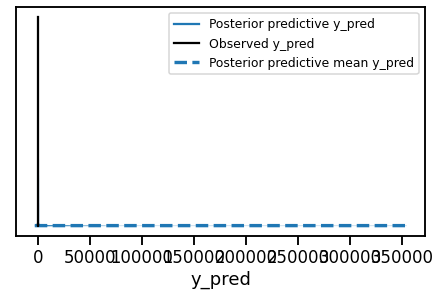

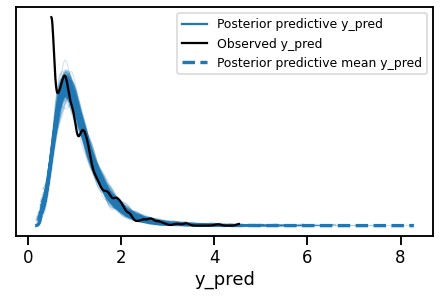

In [32]:
plot_pps(hierachical_dict)

### Plot the trace

array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>],
       [<AxesSubplot:title={'center':'μ_μ'}>,
        <AxesSubplot:title={'center':'μ_μ'}>],
       [<AxesSubplot:title={'center':'μ_λ'}>,
        <AxesSubplot:title={'center':'μ_λ'}>],
       [<AxesSubplot:title={'center':'σ_μ'}>,
        <AxesSubplot:title={'center':'σ_μ'}>],
       [<AxesSubplot:title={'center':'σ_λ'}>,
        <AxesSubplot:title={'center':'σ_λ'}>]], dtype=object)

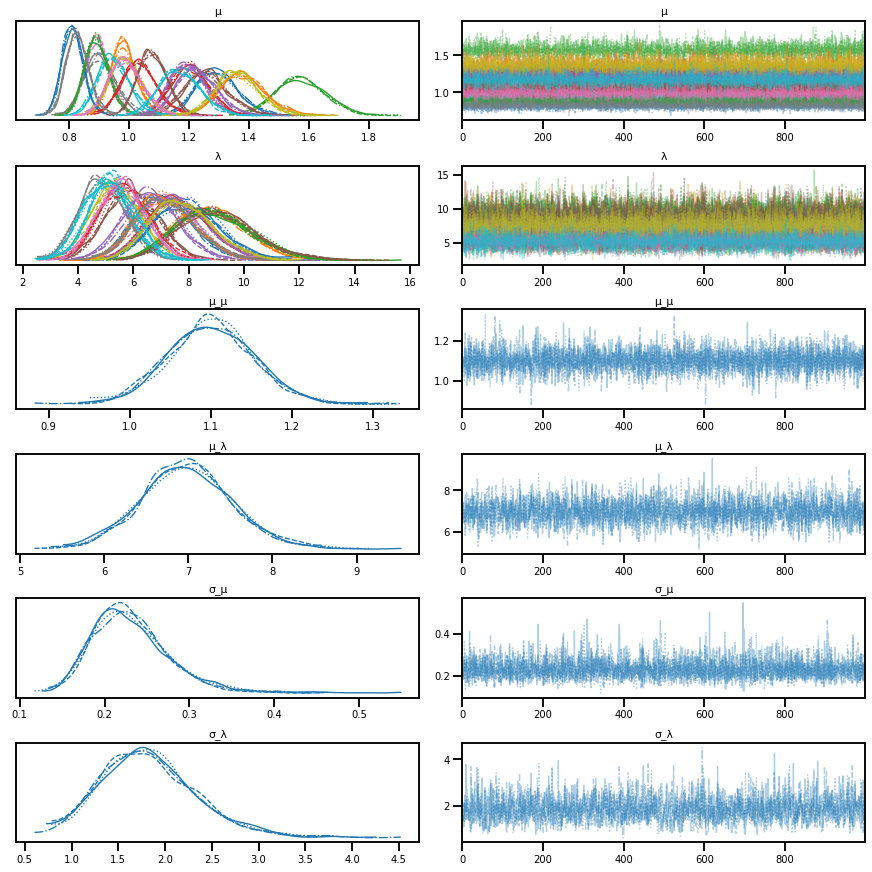

In [33]:
az.plot_trace(hierachical_dict["trace"])